In [1]:
import torch
import os
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [3]:
source_dir = "captured_dataset"
train_ratio=0.8

train_dir = os.path.join(source_dir, 'train')
test_dir = os.path.join(source_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)

# Process each class directory
for class_name in os.listdir(source_dir):
    class_dir = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_dir) or class_name in ['train', 'test']:
        continue
        
    # Create corresponding directories in train and test
    os.makedirs(os.path.join(train_dir, class_name))
    os.makedirs(os.path.join(test_dir, class_name))
    
    # Get list of all files
    files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    num_files = len(files)
    num_train = int(num_files * train_ratio)
    
    # Randomly shuffle files
    import random
    random.shuffle(files)
    
    # Copy files to train directory
    for f in files[:num_train]:
        shutil.copy2(
            os.path.join(class_dir, f),
            os.path.join(train_dir, class_name, f)
        )
        
    # Copy files to test directory
    for f in files[num_train:]:
        shutil.copy2(
            os.path.join(class_dir, f),
            os.path.join(test_dir, class_name, f)
        )

print(f"Dataset split complete:")
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

NameError: name 'shutil' is not defined

In [40]:
# Define dataset paths
dataset_path = "captured_dataset"

# Define transformations for the dataset (resize and normalize images)
transform = transforms.Compose([
    transforms.Grayscale(),       # Convert images to grayscale
    transforms.ToTensor(),        # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load datasets
training_data = datasets.ImageFolder(root=dataset_path + "/train", transform=transform)
test_data = datasets.ImageFolder(root=dataset_path + "/test", transform=transform)

# Create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check dataset structure
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 32, 32])
Shape of y: torch.Size([64]) torch.int64


In [43]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [55]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [46]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [56]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.650932  [   64/ 3044]
loss: 1.661658  [  384/ 3044]
loss: 1.672495  [  704/ 3044]
loss: 1.626094  [ 1024/ 3044]
loss: 1.643517  [ 1344/ 3044]
loss: 1.661088  [ 1664/ 3044]
loss: 1.663951  [ 1984/ 3044]
loss: 1.698299  [ 2304/ 3044]
loss: 1.667179  [ 2624/ 3044]
loss: 1.678448  [ 2944/ 3044]
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.654606 

Epoch 2
-------------------------------
loss: 1.653578  [   64/ 3044]
loss: 1.626534  [  384/ 3044]
loss: 1.646765  [  704/ 3044]
loss: 1.681803  [ 1024/ 3044]
loss: 1.658769  [ 1344/ 3044]
loss: 1.678995  [ 1664/ 3044]
loss: 1.627412  [ 1984/ 3044]
loss: 1.673730  [ 2304/ 3044]
loss: 1.680678  [ 2624/ 3044]
loss: 1.646783  [ 2944/ 3044]
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.649307 

Epoch 3
-------------------------------
loss: 1.664869  [   64/ 3044]
loss: 1.655003  [  384/ 3044]
loss: 1.691716  [  704/ 3044]
loss: 1.652140  [ 1024/ 3044]
loss: 1.656324  [ 1344/ 3044]
loss: 1.635550  [ 1664/ 30

In [48]:
torch.save(model.state_dict(), "new-model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


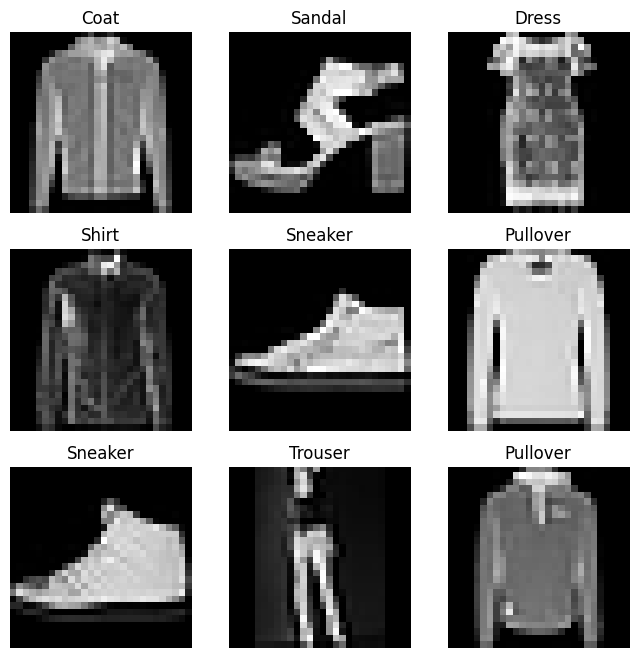

In [12]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()